In [1]:
%load_ext autoreload
%autoreload 2

# Import

In [2]:
from importlib.util import find_spec
if find_spec("costa_rican") is None:
    import sys
    sys.path.append('..')

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [4]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('../input/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('../input/costa-rican-household-poverty-prediction/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


130개의 integer columns, 8개의 float, 5개의 object column 존재.     
integer column은 discret or binary.
object column은 모델에 넣어주기 위해 별도의 처리가 필요하다.


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


# Data

## Integer columns

In [7]:
from costa_rican.utils.visualization import BarUniqueDtypeNum

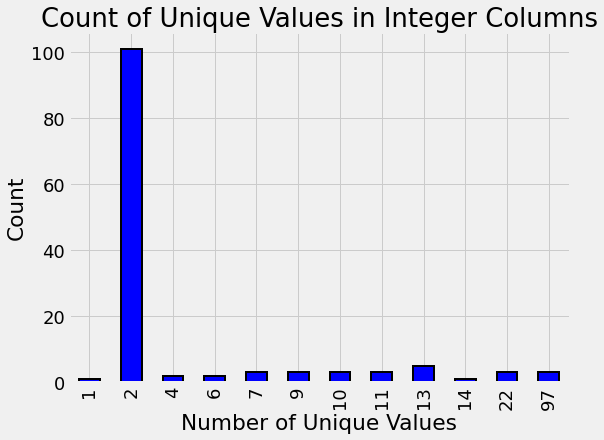

In [8]:
unique_num_by_dtypes = BarUniqueDtypeNum(train)
unique_num_by_dtypes(np.int64)

2에 해당하는 column은 binary를 의미한다. 많은 경우에 boolean column은 household level 정보를 담고 있다.
추후 특징을 추출할 때 household 레벨이 아닌 열만 aggregation 해준다.

## Float columns

In [9]:
from collections import OrderedDict
from costa_rican.utils.visualization import KdePlotByTarget

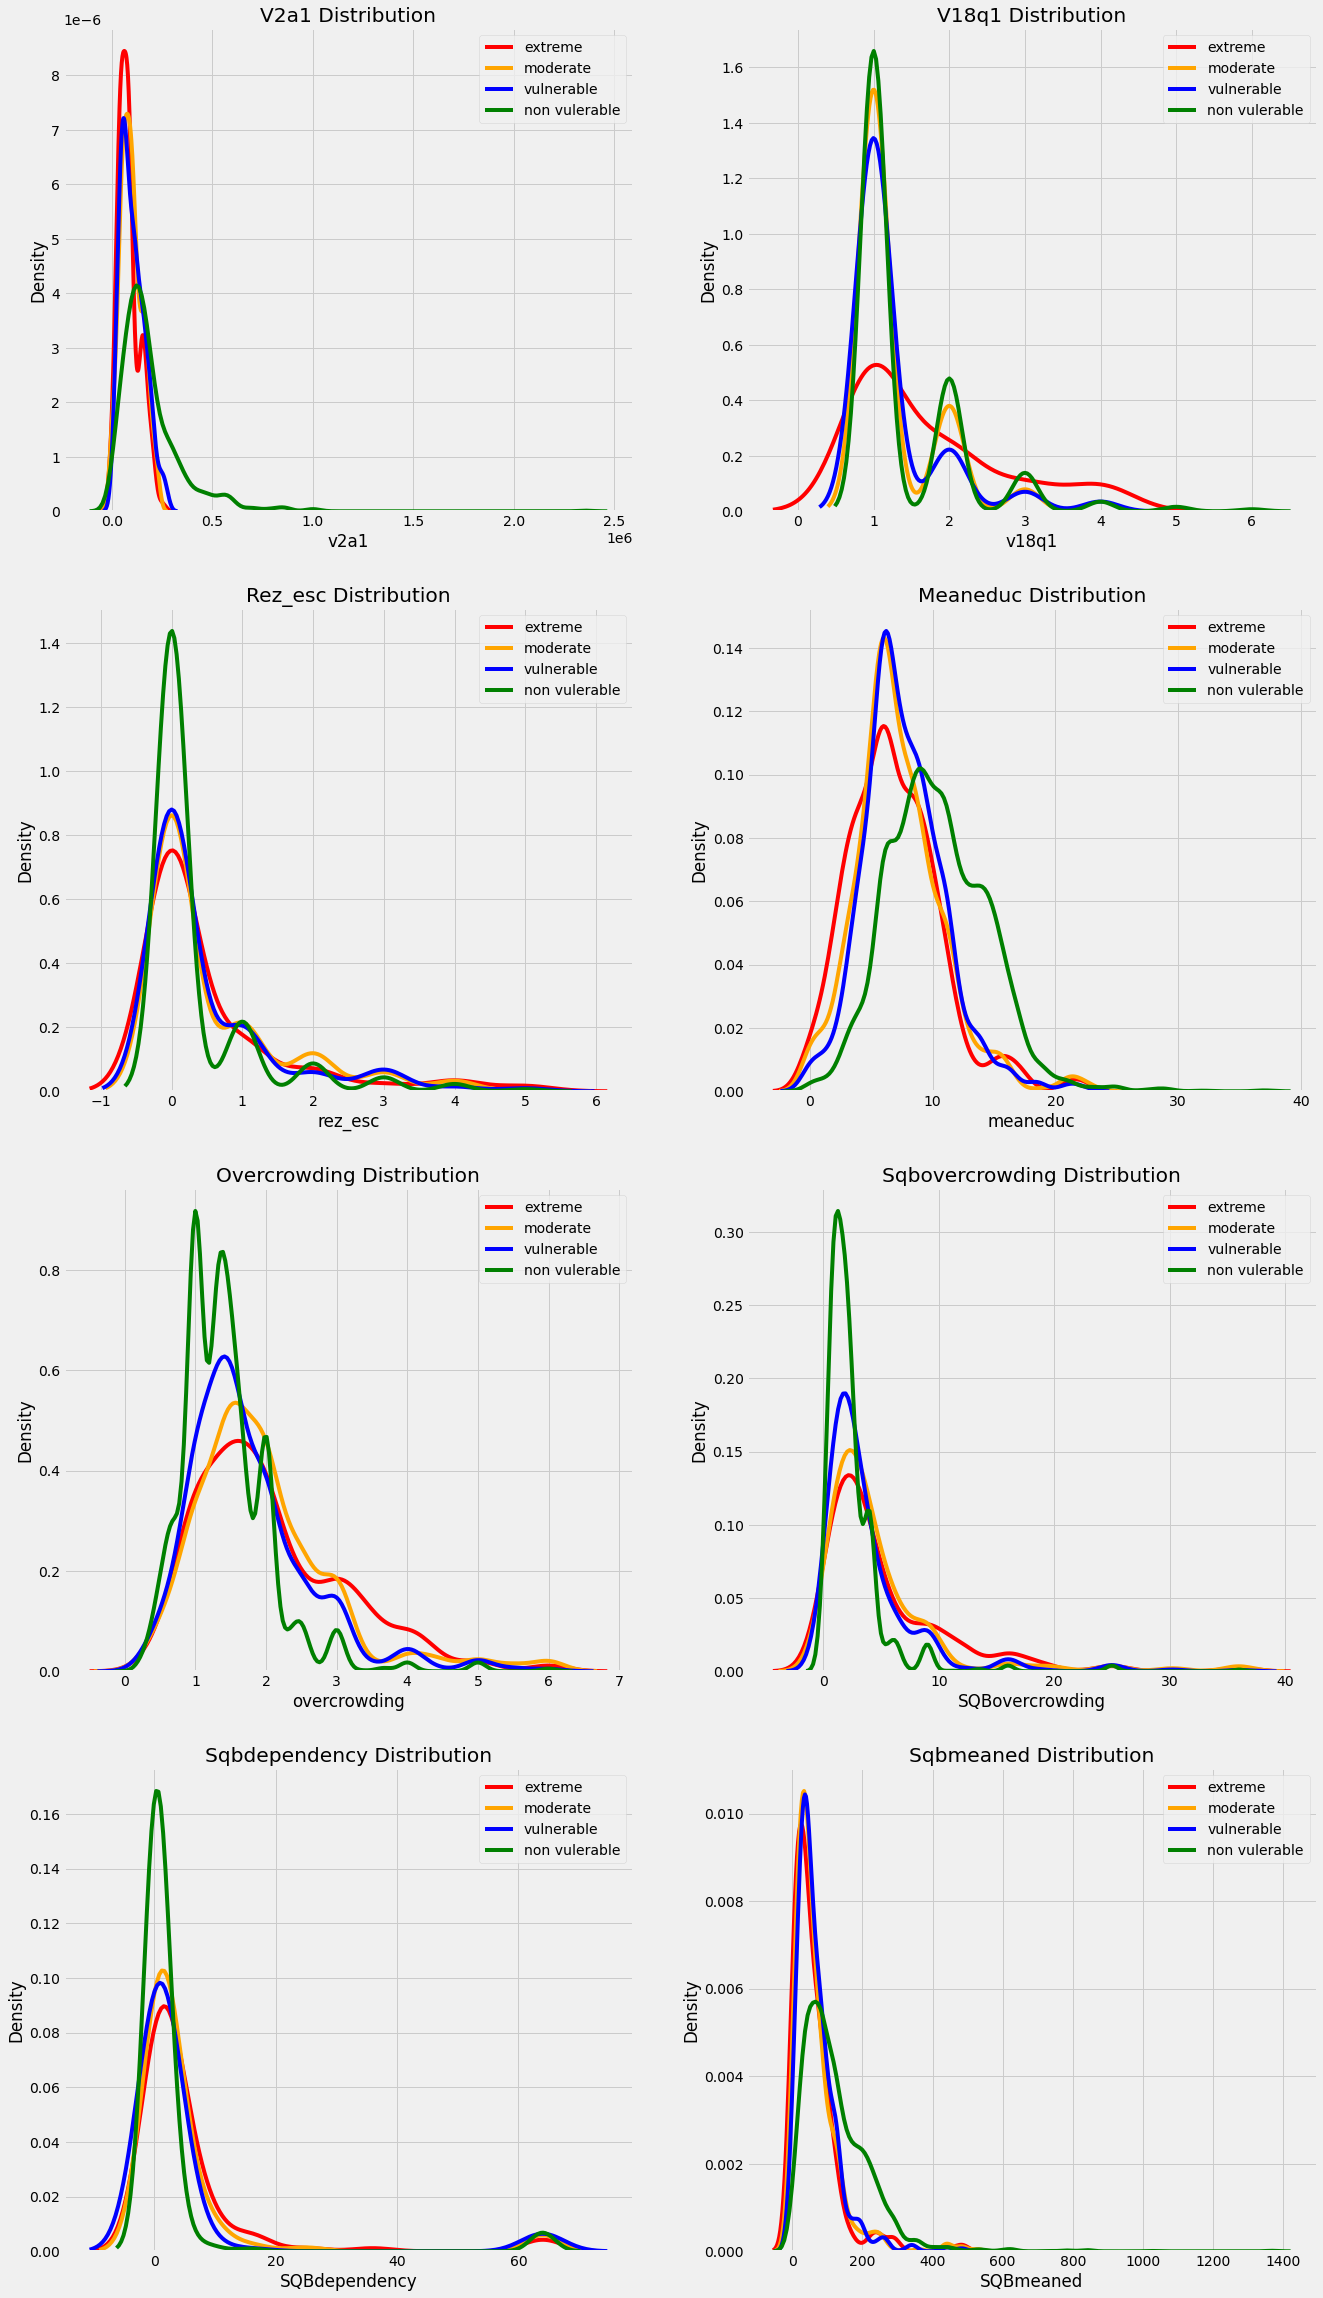

In [10]:
kde_plot_by_target = KdePlotByTarget(train)
kde_plot_by_target("float")

추후 correlation을 그려보겠지만 우선 `meaneduc` 과 같은 특징들의 분포를 통해 household의 평균 교육 수준이 높을수록 가난하지 않은(poverty level이 4에 가까움) 것을 확인할 수 있다.

## Object columns

In [11]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


`Id` and `idhogar`를 제외한 나머지 3개 column의 경우 문자열과 숫자로 구성되어 있는 것을 확인할 수 있다.
document에 따르면 아래와 같다.

- `dependency`: dependency rate, calculated = (19살 아래 or 64살 위 인원 수) / (19살 ~ 64살 인원 수)
- `edjefe`: 남자 세대주의 교육 기간
- `edjefa`: 여자 세대주의 교육 기간
=> "yes" = 1 "no" = 0 으로 mapping 한다.

In [12]:
from costa_rican.utils.eda import ReplaceValues

In [13]:
mapping = {"yes": 1, "no": 0}
columns = ['dependency', 'edjefa', 'edjefe']
replace_object_value = ReplaceValues(mapping)

train = replace_object_value(train, columns)
test = replace_object_value(test, columns)

In [14]:
train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [15]:
from costa_rican.utils.visualization import KdePlotByTargetAndColumn

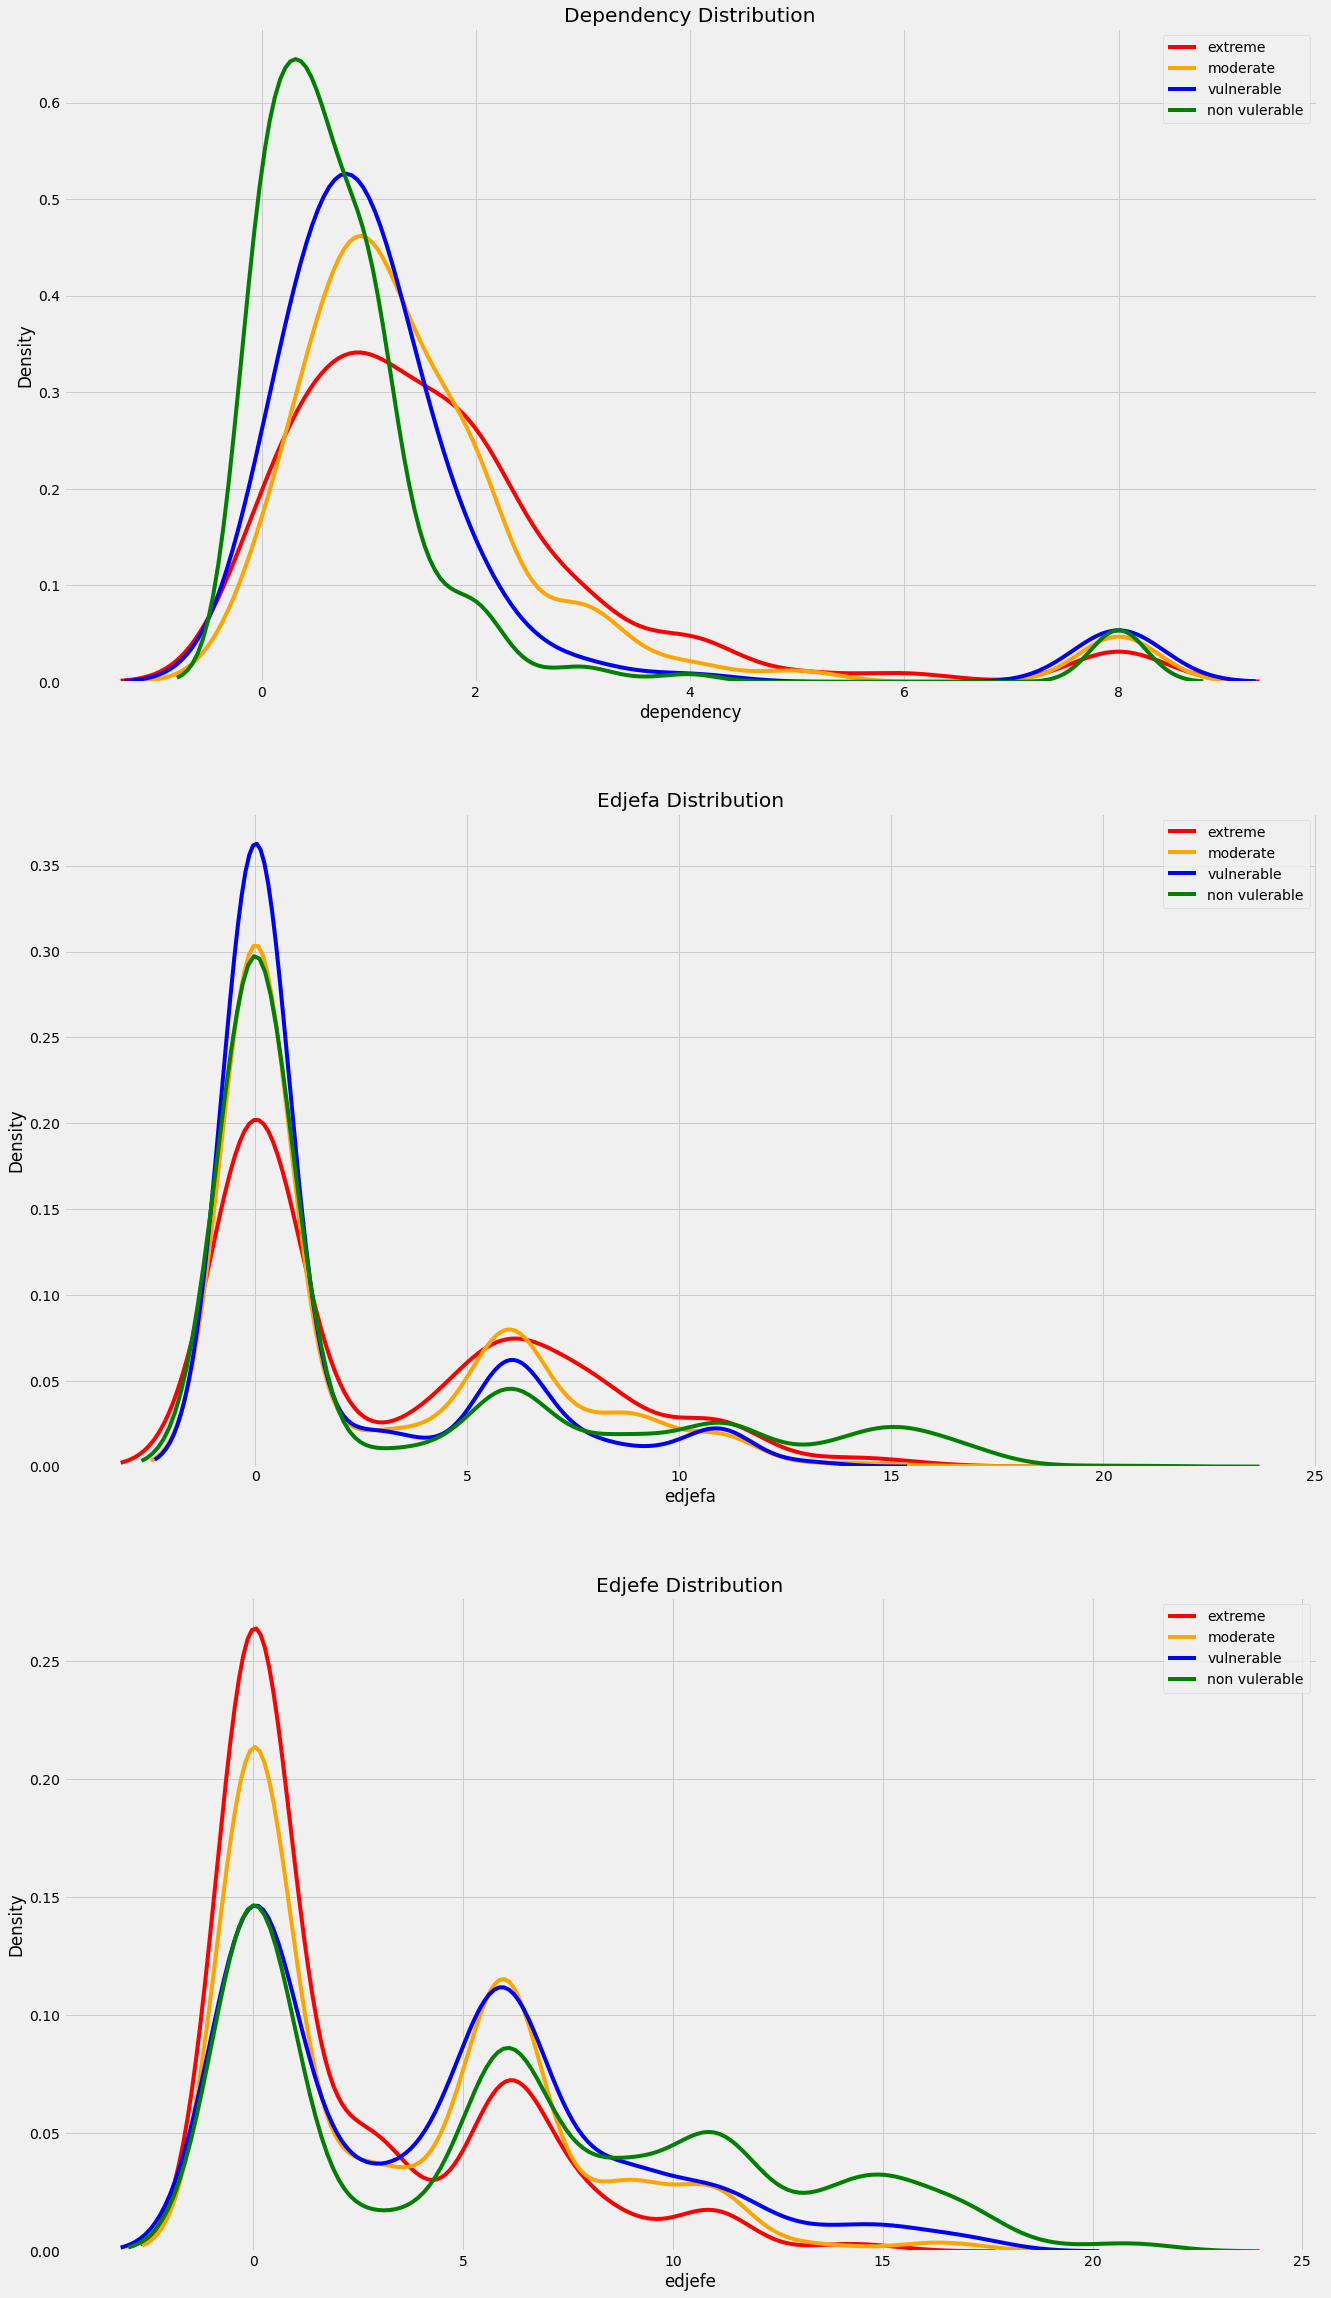

In [16]:
columns = ['dependency', 'edjefa', 'edjefe']
kde_plot_by_columns = KdePlotByTargetAndColumn(train)
kde_plot_by_columns(columns)

텍스트를 숫자로 바꿔줌으로써 model에 넣어줄 수 있게 되었다.

train 데이터와 test 데이터는 같은 방식으로 처리되어야 한다.
한가지 방법으로 train과 test를 병합하여 처리한 후 나눠줄 수 있다.

In [17]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

/tmp/ipykernel_1252878/1415462644.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train.append(test, ignore_index = True)


## Exploring label distribution

각 클래스별로 데이터의 imbalacne를 확인한다. 세대주가 존재하는 row(parentesco1 == 1)만 확인한다.     

In [18]:
from costa_rican.utils.visualization import ShowLabelDistribution

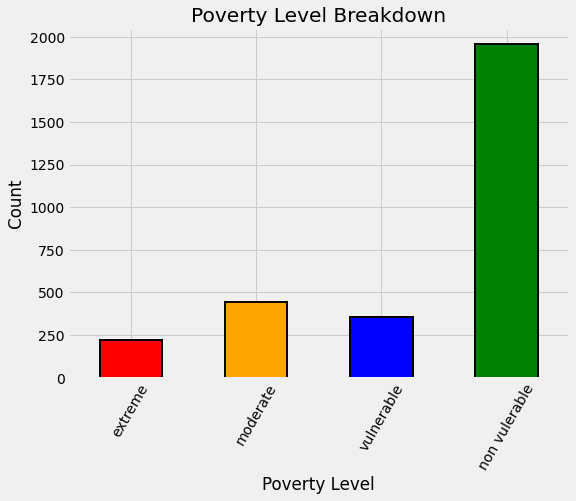

In [20]:
label_distribution_plot = ShowLabelDistribution()
label_counts = label_distribution_plot(data)

In [21]:
label_counts

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

주어진 데이터가 imbalance 데이터인 것을 확인할 수 있다.
_non_vulnerable_ 에해당하는 데이터가 다른 클래스에 해당하는 데이터보다 많음.
extreme poverty에 해당하는 데이터가 가장 작음.
=> 성능 최적화를 위해 조정할 필요가 있다. 

데이터가 imbalance할 경우 모델이 minority 클래스를 보는 횟수가 줄어들기 때문에 작은 수의 클래스에 해당하는 데이터를 예측하기 어려워진다.
이를 해결하기 위해 oversampling 또는 undersampling을 수행할 수 있는데, 이 노트북에서는 oversampling을 수행한다.

## Addressing Wrong labels

현재 주어진 데이터에서는 같은 `household`에 속해있더라도 다른 `poverty level`을 갖는 샘플들이 존재한다.     
이 경우 세대주에 해당하는 샘플의 `poverty lavel`을  true label로 생각하도록 한다.     
실제 문제에서는 왜 이러한 문제들이 발생했는지도 고려해봐야 한다.

### Identify errors

각 household에 해당하는 개별 데이터가 모두 같은 `poverty level`을 갖는지 확인하기 위해, group화를 진행한다.

In [22]:
from costa_rican.utils.eda import num_different_poverty_level

In [24]:
not_equal = num_different_poverty_level(train)

There are 85 households where the family members do not all have the same target


In [26]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


현재 문제에서는 위와 같이 같은 가구내 다른 target 값을 갖는 샘플이 있을 경우 세대주의 label을 사용하도록 문제 제공자가 명시하였다.     
실제 문제에서는 어떻게 처리할 건지에 대한 고민이 필요하다.

## 세대주가 없는 가구

세대주가 없는데 가구 내 레이블이 다른 경우 어떻게 처리할 것인가?

In [43]:
from costa_rican.utils.eda import get_num_without_household

In [45]:
households_no_head = get_num_without_household(train)

There are 15 households without a head.


In [46]:
num_different_poverty_level(households_no_head)

There are 0 households where the family members do not all have the same target


Series([], Name: Target, dtype: bool)

다행히도 세대주가 없는 가구 중 다른 label을 갖는 개별 샘플은 존재하지 않는다.    
학습 시에는 위와 같은 결과와 상관없이 세대주가 존재하지 않는 가구에 포함되는 샘플들은 훈련에 사용하지 않는다.

## Correct errors

세대주가 존재하지 않는 샘플과 다른 poverty level을 갖는 샘플을 수정한다.

In [56]:
from costa_rican.utils.eda import correct_poverty_levels

In [57]:
correct_poverty_levels(train)

Before
There are 0 households where the family members do not all have the same target
After
There are 0 households where the family members do not all have the same target


## Missing variables

EDA에서는 missing value(결측치)를 찾고 어떻게 다룰 것인지 판단하는 과정이 포함된다.      
결측치는 머신러닝 모델에 들어가기 전에 모두 처리되어야 한다.     

In [65]:
from costa_rican.utils.eda import get_missing_val_info

In [68]:
missing = get_missing_val_info(data)
missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


3가지 특징의 null 값이 매우 많은 것을 확인할 수 있다.     

### v18q1

`v18q1`: 한 가구가 가지고 있는 tablet의 수
가구 단위의 데이터이므로 세대주 샘플만 추출하여 정보를 확인한다.

In [74]:
from costa_rican.utils.visualization import BarValueCounts

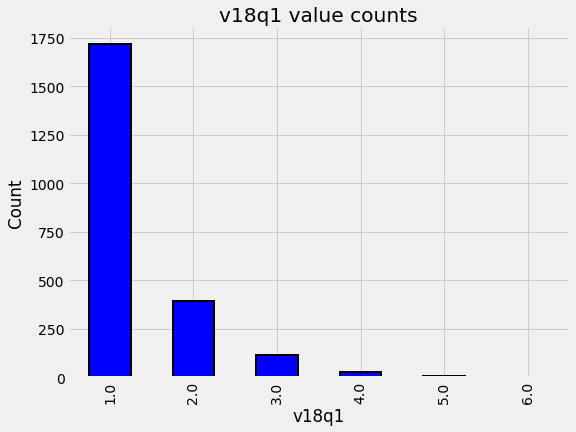

In [75]:
plot_value_counts = BarValueCounts()
plot_value_counts(data, 'v18q1')

`v18q1` 열을 통해 대부분의 가정들은 하나의 테블릿을 가지고 있는 것으로 생각될 수 있으나, 결측치를 고려해보아야 한다.     
`v18q1` 특징의 결측치는 테블릿을 하나도 가지고 있지 않은 가정을 의미할 수 있다.     
`v18q`는 가정이 테블릿을 가지고 있는지 여부를 알려주는 특징이므로 이를 이용하여 확인해본다.

In [77]:
heads = data.loc[data['parentesco1'] == 1].copy()

In [84]:
from costa_rican.utils.eda import get_null_by_group

In [85]:
get_null_by_group(heads, 'v18q', 'v18q1')

v18q
0    8044
1       0
Name: v18q1, dtype: int64


위의 결과에서 확인할 수 있듯이 `v18q1` 특징의 결측치는 테블릿을 가지고 있지 않은 것을 의미한다.

In [89]:
data = fill_nan_with_zero(data, 'v18q1')

### v2a1

`v2a1` : 월세 납부액     
`v2a1`의 결측치를 확인하는데 `tipovivi_` 특징을 같이 보는 것이 좋다.    
`tipovivi_`는 건물 소유 여부를 나타내는 특징으로 건물을 소유하고 있는 가정의 경우 `v2a1`특징에 결측치를 가지고 있을 수 있다. 

In [120]:
from costa_rican.utils.visualization import NullCountsByCols

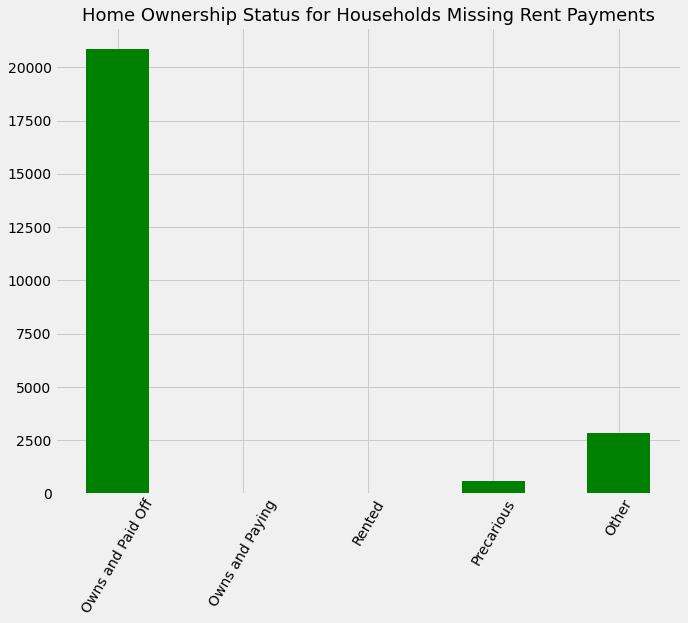

In [121]:
null_counts_by_cols = NullCountsByCols()
xtickslabels = ["Owns and Paid Off", "Owns and Paying", "Rented", "Precarious", "Other"]
null_counts_by_cols(data, "v2a1", "tipo", xtickslabels, "Home Ownership Status for Households Missing Rent Payments")


home ownership variables의 의미는 아래와 같다.     
tipovivi1 == 1: own and fully paid house     
tipovivi2 == 1: own, paying in installments     
tipovivi3 == 1: rented     
tipovivi4 == 1: precarious     
tipovivi5 == 1: other(assigned, borrowed)      

위 그래프르르 통해 월세에 해당하는 `v2a1` 특징에서 null값을 갖는 샘플의 대부분은 본인 소유의 집을 가지고 있는 것을 알 수 있다.    
해당 사항이 없는 몇가지 샘플에 대해서는 이유를 알 수 없다.

본인 소유의 집을 가지고 있어 월세를 내지 않는 데이터에 대해서는 결측치를 0으로 대체한다.     
집을 소유하고 있지 않은데 결측치를 갖는 몇가지 샘플에 대해서는 추후 다른 숫자(평균, 중간값 등)로 대체해준다. 이떄 본래 결측치였다는 것을 모델에게 알려주기 위해 새로운 특징을 추가한다.

In [133]:
def fill_null_v2a1(df):
    df.loc[(data["tipovivi1"] == 1), 'v2a1'] = 0
    df['v2a1-missing'] = data['v2a1'].isnull()
    return df

In [134]:
data = fill_null_v2a1(data)
data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

### rez_esc

`rez_esc` 는 학교에 다니는 연수를 나타낸다.      
이 특징에 대한 결측치의 원인은 가정 중에 학교에 다니는 나이에 해당하는 자식 없는 것으로 예상할 수 있다.

In [135]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [136]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403    
위 링크에 따르면 `rez_esc` 특징은 7~19세 사이의 나이대에 해당하는 샘플에서만 정의된 것을 알 수 있다.     
따라서 해당 나이 범위에 해당하지 않은 샘플의 결측치는 0으로 설정할 수 있다.     
그에 해당하지 않는 샘플의 경우 이전과 같이 결측치임을 알려주는 새로운 열을 추가한 후 다른 숫자로 대체한다.

In [137]:
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0
data['rez_esc-missing'] = data['rez_esc'].isnull()

competition discussion에 따르면 `rez_esc` 특징의 최대값은 5이다.     
따라서 해당 값보다 큰 값을 갖는 샘플은 5로 값을 제한한다.

In [138]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Plot Two categorical value

범주형 특징이 서로 어떻게 연관되어 있는지 확인하기 위해 plot을 그려본다.     


In [170]:
from costa_rican.utils.visualization import PlotCategoricals

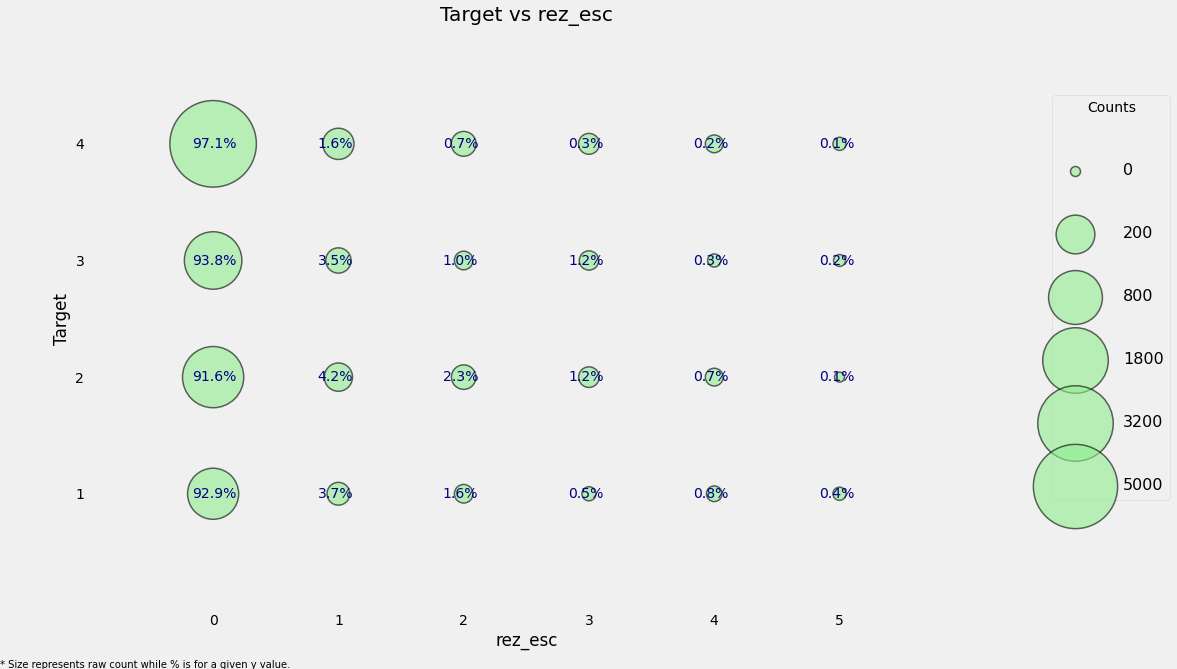

In [171]:
plot_categoricals = PlotCategoricals()
plot_categoricals(data, 'rez_esc', 'Target')

poverty level == 1인 사람들 중 93%에 해당하는 사람들이 학교 교육을 받지 못하였으며 800명보다 작은 사람이 포함되는 것을 알 수 있다.

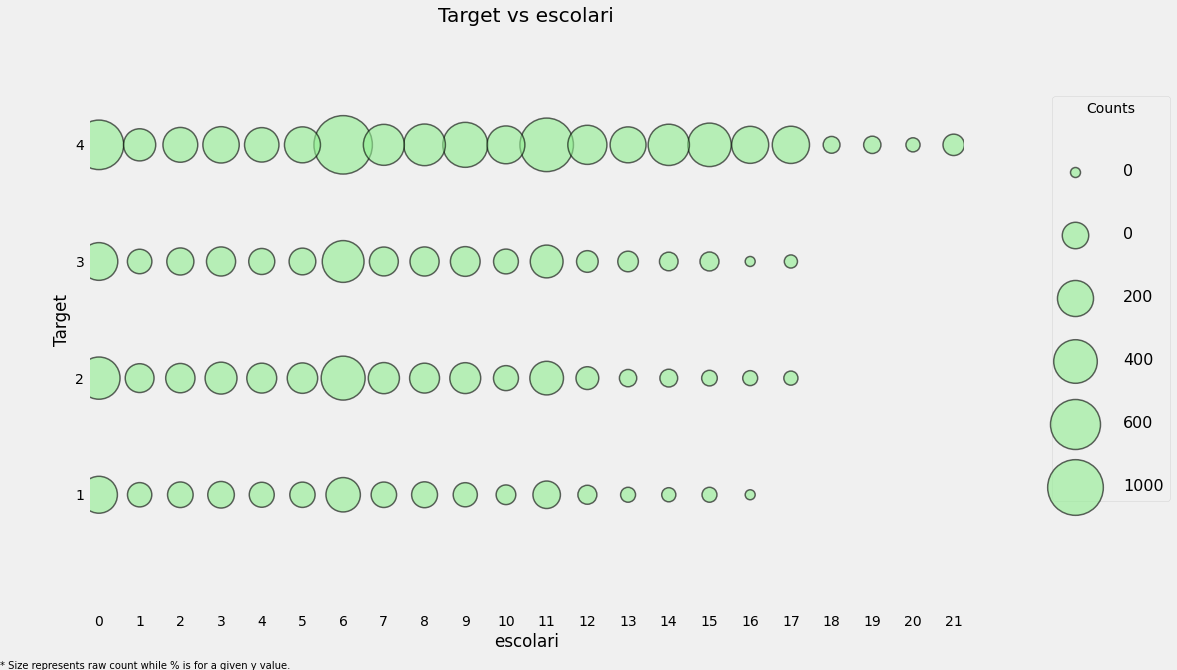

In [172]:
plot_categoricals(data, 'escolari', "Target", annotate=False)

각 열에 남아있는 결측치는 `Imputation`이라고 불리는 과정을 통해 채운다.    
가장 간편하고 효율적인 방법중 하나는 결측치를 모두 중간값으로 채우는 것이다.

결측치를 처리하는 마지막 방식으로 타겟의 클래스 별로 결측치의 수를 plot하는 방식이 있다.

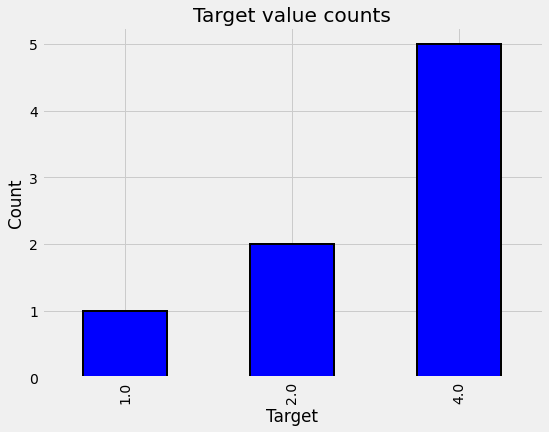

In [173]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

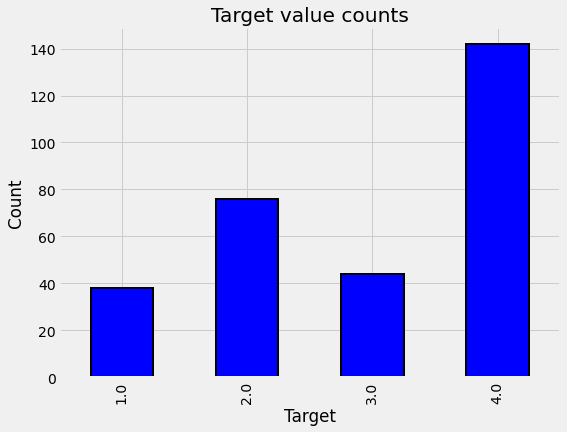

In [174]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

poverty_level == 2에 결측치의 수가 많은 것을 통해 결측치가 빈곤을 판별하는데 모델에 도움이 될 수도 있는 것을 알 수 있다.      
__Notion__: 간혹 결측치는 다른 정보들만큼 중요한 의미를 가지고 있을 수 있으므로 처리하는데 주의하도록 한다.

# Feature engineering 

현재 몇가지 특징들이 household 단위의 정보를 가지고 있지만, model을 훈련하기 위해서는 모든 정보를 househole 단위로 나타낼 필요가 있다.     
=> `gropuby`와 `agg`를 활용한다.

## Column definition     

전체 과정은 아래와 같다.    
1. 특징들을 `household level`과 `individual level`로 나눈다.
2. 각 레벨 특징들에 대해 적절한 aggregation을 수행한다.
   1. ordinal 특징들에 대해서는 통계적 접근이 가능하다.
   2. Boolean 특징들에 대해서는 더 적은 방식으로 aggregation이 가능하다.
3. 나누어둔 특징들을 다시 결합한다.


## Define Variable categories      
각 변수들에 대해 몇몇 다른 카테고리가 존재한다.     
1. individual variables: 가구 단위가 아닌 개인에 대한 특징들
   1. Boolean: Yes or No (1 or 0)
   2. Ordered discrete: 순서가 의미가 있는 정수
2. Household variables:
   1. Boolean
   2. Ordered discrete
   3. Continuous numeric
3. Squared variables: 특징들의 제곱에 의해서 파생
4. Id variables: 모델에 특징으로 사용되지 않는 샘플을 구분 짓기 위한 열

In [175]:
id_ = ["Id", "idhogar", "Target"]